In [17]:
import os

import copy
import random
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

import numpy as np
import pandas as pd 

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, auc #, roc_curve, precision_recall_curve
from sklearn.metrics import average_precision_score, confusion_matrix
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve
from sklearn.preprocessing import MinMaxScaler

import scipy.stats as st
from scipy.stats import norm
from tabulate import tabulate

from logging_utils import *
from logging_utils import myLogger, print_log, close_loggers 

from plot_utils import plot_mean_ROC, plot_mean_PR
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

In [32]:
SEED = 1970
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

color_index = list(mcolors.CSS4_COLORS)
colors = mcolors.CSS4_COLORS

data_path = './data/'
mean_metrics = 'mean_metrics.csv'
mean_metrics_VA = 'mean_metrics_231217.csv'

mean_metrics_cols = ['date', 'model', 'image_size', 'batch_size', 'channel', 'test_set','roc_auc', 'pr_auc', 'f1', 'precision', 'recall']
metrics_cols = ['roc_auc', 'pr_auc', 'f1', 'precision', 'recall']
metric_name = ['ROC AUC', 'PR AUC', 'F1', 'Precision', 'Recall']
test_label = ['test_loc', 'test_NoL']
test_classes = {'test_loc' : [5812, 336], 'test_NoL' : [3742, 835]}

channel_label = ['RGB', '3', 'EI', 'MI', '5']
channel_label_alt = ['RGB', 'HSV', 'HSV + EI', 'HSV + MI', 'HSV + EI + MI']

In [19]:
df_mean_metrics = pd.read_csv(f'{data_path}/{mean_metrics}')
df_mean_metrics.shape

(90, 12)

In [20]:
df_mean_metrics_VA = pd.read_csv(f'{data_path}/{mean_metrics_VA}')
df_mean_metrics_VA.dropna(inplace = True)
df_mean_metrics_VA.shape

(60, 12)

In [21]:
df_mean_metrics.tail(10)

,date,model,image_size,batch_size,channel,roc_auc,pr_auc,f1,precision,recall,test_set,uuid
80,20231212,v2b2,512,32,RGB,0.657428,0.314718,0.294989,0.359107,0.250299,test_NoL,6b812a27-2576-46dd-8c0d-4237cd47e3e3
81,20231212,v2b2,512,32,3,0.658664,0.334168,0.379218,0.301341,0.511377,test_NoL,6b812a27-2576-46dd-8c0d-4237cd47e3e3
82,20231212,v2b2,512,32,EI,0.666849,0.343522,0.362178,0.347253,0.378443,test_NoL,6b812a27-2576-46dd-8c0d-4237cd47e3e3
83,20231212,v2b2,512,32,MI,0.691619,0.388085,0.414093,0.346807,0.513772,test_NoL,6b812a27-2576-46dd-8c0d-4237cd47e3e3
84,20231212,v2b2,512,32,5,0.700362,0.387508,0.417349,0.349194,0.518563,test_NoL,6b812a27-2576-46dd-8c0d-4237cd47e3e3
85,20231212,v2b2,512,32,RGB,0.845063,0.285633,0.274448,0.291946,0.258929,test_loc,6b812a27-2576-46dd-8c0d-4237cd47e3e3
86,20231212,v2b2,512,32,3,0.866061,0.319514,0.340996,0.251412,0.529762,test_loc,6b812a27-2576-46dd-8c0d-4237cd47e3e3
87,20231212,v2b2,512,32,EI,0.875524,0.336718,0.361386,0.309322,0.434524,test_loc,6b812a27-2576-46dd-8c0d-4237cd47e3e3
88,20231212,v2b2,512,32,MI,0.871052,0.360573,0.358240,0.273011,0.520833,test_loc,6b812a27-2576-46dd-8c0d-4237cd47e3e3
89,20231212,v2b2,512,32,5,0.873223,0.360022,0.379592,0.288820,0.553571,test_loc,6b812a27-2576-46dd-8c0d-4237cd47e3e3


In [22]:
df_mean_metrics_VA.tail(10)

,date,model,image_size,batch_size,channel,roc_auc,pr_auc,f1,precision,recall,test_set,uuid
90,20231217,resnet50v2,128,128,RGB,0.668878,0.356077,0.388423,0.298903,0.554491,test_NoL,49762336-6645-440b-ae72-e8503cfcd357
91,20231217,resnet50v2,128,128,3,0.678520,0.388056,0.406622,0.357923,0.470659,test_NoL,49762336-6645-440b-ae72-e8503cfcd357
92,20231217,resnet50v2,128,128,EI,0.670401,0.361007,0.394070,0.328025,0.493413,test_NoL,49762336-6645-440b-ae72-e8503cfcd357
93,20231217,resnet50v2,128,128,MI,0.664957,0.373435,0.399593,0.347173,0.470659,test_NoL,49762336-6645-440b-ae72-e8503cfcd357
94,20231217,resnet50v2,128,128,5,0.683741,0.387475,0.409399,0.362963,0.469461,test_NoL,49762336-6645-440b-ae72-e8503cfcd357
95,20231217,resnet50v2,128,128,RGB,0.877612,0.366712,0.369099,0.288591,0.511905,test_loc,49762336-6645-440b-ae72-e8503cfcd357
96,20231217,resnet50v2,128,128,3,0.872858,0.341542,0.371882,0.300366,0.488095,test_loc,49762336-6645-440b-ae72-e8503cfcd357
97,20231217,resnet50v2,128,128,EI,0.870275,0.338591,0.382387,0.313093,0.491071,test_loc,49762336-6645-440b-ae72-e8503cfcd357
98,20231217,resnet50v2,128,128,MI,0.871080,0.331929,0.354949,0.287293,0.464286,test_loc,49762336-6645-440b-ae72-e8503cfcd357
99,20231217,resnet50v2,128,128,5,0.882652,0.367597,0.375000,0.283537,0.553571,test_loc,49762336-6645-440b-ae72-e8503cfcd357


In [23]:
uuid_left = set(df_mean_metrics.uuid)
uuid_right = set(df_mean_metrics_VA.uuid)
uuid_add = uuid_right - uuid_left
# print(uuid_add)

df_mean_metrics_all = pd.concat([df_mean_metrics, df_mean_metrics_VA.loc[df_mean_metrics_VA.uuid.isin(uuid_add)]], axis = 0).reindex()

In [25]:
def plot_metrics(df_mean_metrics):
    df_mean = df_mean_metrics.groupby(['test_set','channel'])['roc_auc'].mean()
    df_mean_all = df_mean_metrics.groupby(['test_set','channel'])[metrics_cols].mean()

    for mi, mn in enumerate(metrics_cols):  
        fig, ax = plt.subplots(figsize=(6, 6), dpi = 100)
        for ti, tn in enumerate(test_label):
            metrics_dict = dict(df_mean_all.loc[test_label[ti]][mn])
            rearr = {}
            for ch in channel_label:
                rearr[ch] = metrics_dict[ch]
            x = list(rearr.keys())
            y = list(rearr.values())
            max_x = np.argmax(y)
            max_y = np.array(y).max()
            ax.plot(max_x, max_y, marker = 'o')
            ax.plot(x, y,
                    color = colors[color_index[ti]],
                    label = f"{mn} for {tn}",
                    lw=2,
                    alpha = 0.9)   
        ax.set(xlabel = "Channels",
                ylabel = mn,
                title = f"Mean {mn} for all channels")   
        ax.legend(loc="lower right")
        plt.show()

In [61]:
def print_metrics_CI(df_mean_metrics_all):
    for ti, tn in enumerate(test_label):
        n_samples = df_mean_metrics_all.loc[(df_mean_metrics_all.test_set == tn)].shape[0]
        print(f'\nTest set - {tn}, {test_classes[tn][0]} bening and {test_classes[tn][1]} malignant samples')
        print(f'{n_samples//5} models results:')
        for mi, metr in enumerate(metrics_cols):
            print(f"{metric_name[mi]}")
            table = []
            m_values = np.zeros(5)
            for ci, ch in enumerate(channel_label):
                df_temp = df_mean_metrics_all.loc[(df_mean_metrics_all.test_set == tn) & (df_mean_metrics_all.channel == ch)]
                ci_metr = st.t.interval(0.95, df = (df_temp.shape[0])-1, loc=np.mean(df_temp[metr].values), scale=st.sem(df_temp[metr].values)) 
                table = table + [[channel_label_alt[ci], f'{np.mean(df_temp[metr].values) * 100:.2f}%', f'({ci_metr[0] * 100:.2f}%, {ci_metr[1] * 100:.2f}%)']]
                m_values[ci] = np.mean(df_temp[metr].values) * 100
            max_i = np.argmax(m_values)
            table[max_i][1] = '-> ' + table[max_i][1] + ' <-'
            print(tabulate(table, ['Channels', 'Mean','95% Confidence interval'], tablefmt="rounded_outline", colalign=('left', "center", "center")))

In [27]:
# print_metrics_CI(df_mean_metrics)

In [62]:
print_metrics_CI(df_mean_metrics_all)


Test set - test_loc, 5812 bening and 336 malignant samples
15 models results:
ROC AUC
╭───────────────┬──────────────┬───────────────────────────╮
│ Channels      │     Mean     │  95% Confidence interval  │
├───────────────┼──────────────┼───────────────────────────┤
│ RGB           │    86.04%    │     (85.13%, 86.95%)      │
│ HSV           │ -> 86.36% <- │     (86.02%, 86.69%)      │
│ HSV + EI      │    86.08%    │     (85.54%, 86.61%)      │
│ HSV + MI      │    86.22%    │     (85.68%, 86.76%)      │
│ HSV + EI + MI │    86.00%    │     (85.31%, 86.70%)      │
╰───────────────┴──────────────┴───────────────────────────╯
PR AUC
╭───────────────┬──────────────┬───────────────────────────╮
│ Channels      │     Mean     │  95% Confidence interval  │
├───────────────┼──────────────┼───────────────────────────┤
│ RGB           │ -> 33.32% <- │     (30.69%, 35.96%)      │
│ HSV           │    32.79%    │     (31.07%, 34.50%)      │
│ HSV + EI      │    32.87%    │     (30.83%, 34.90%

In [29]:
# plot_metrics(df_mean_metrics)

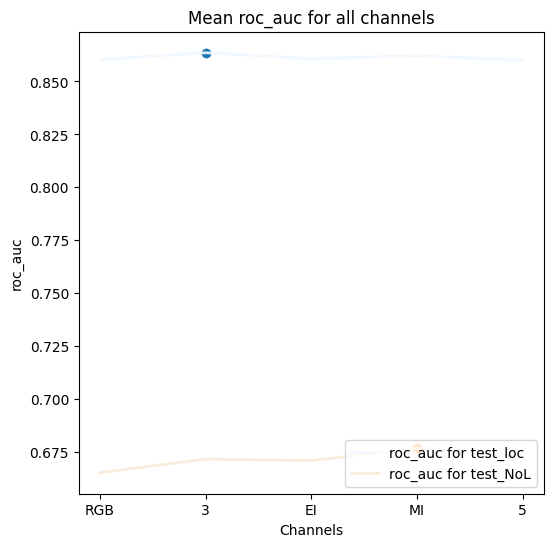

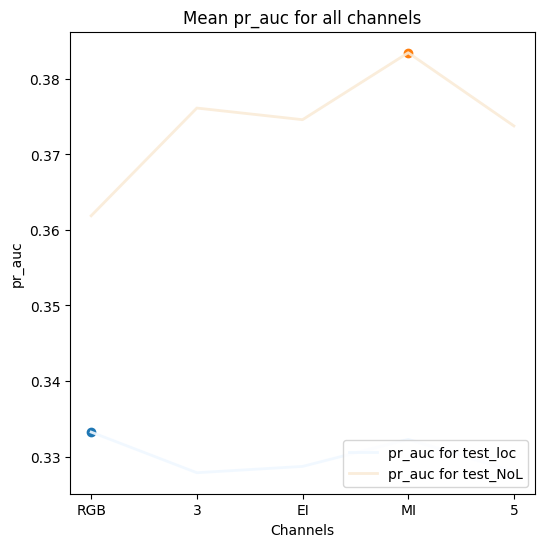

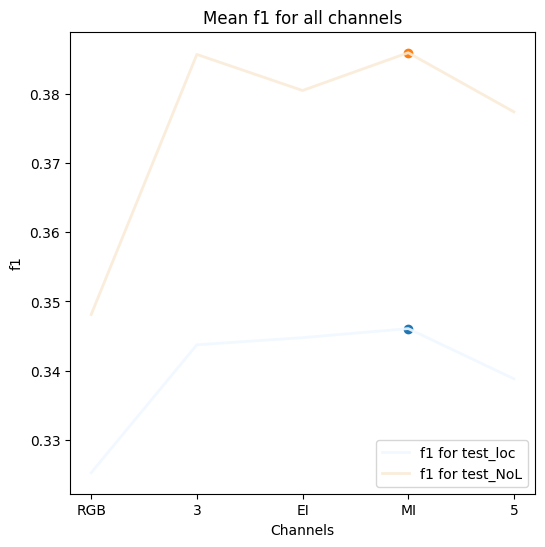

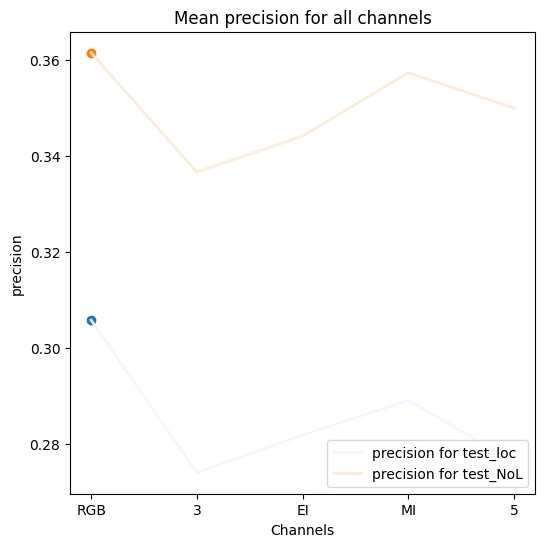

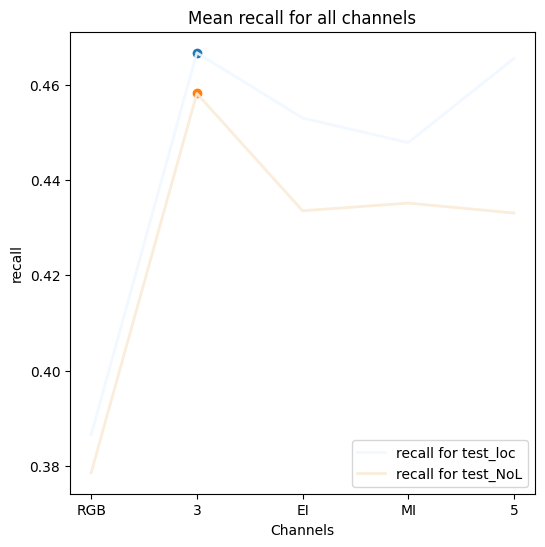

In [30]:
plot_metrics(df_mean_metrics_all)

[]

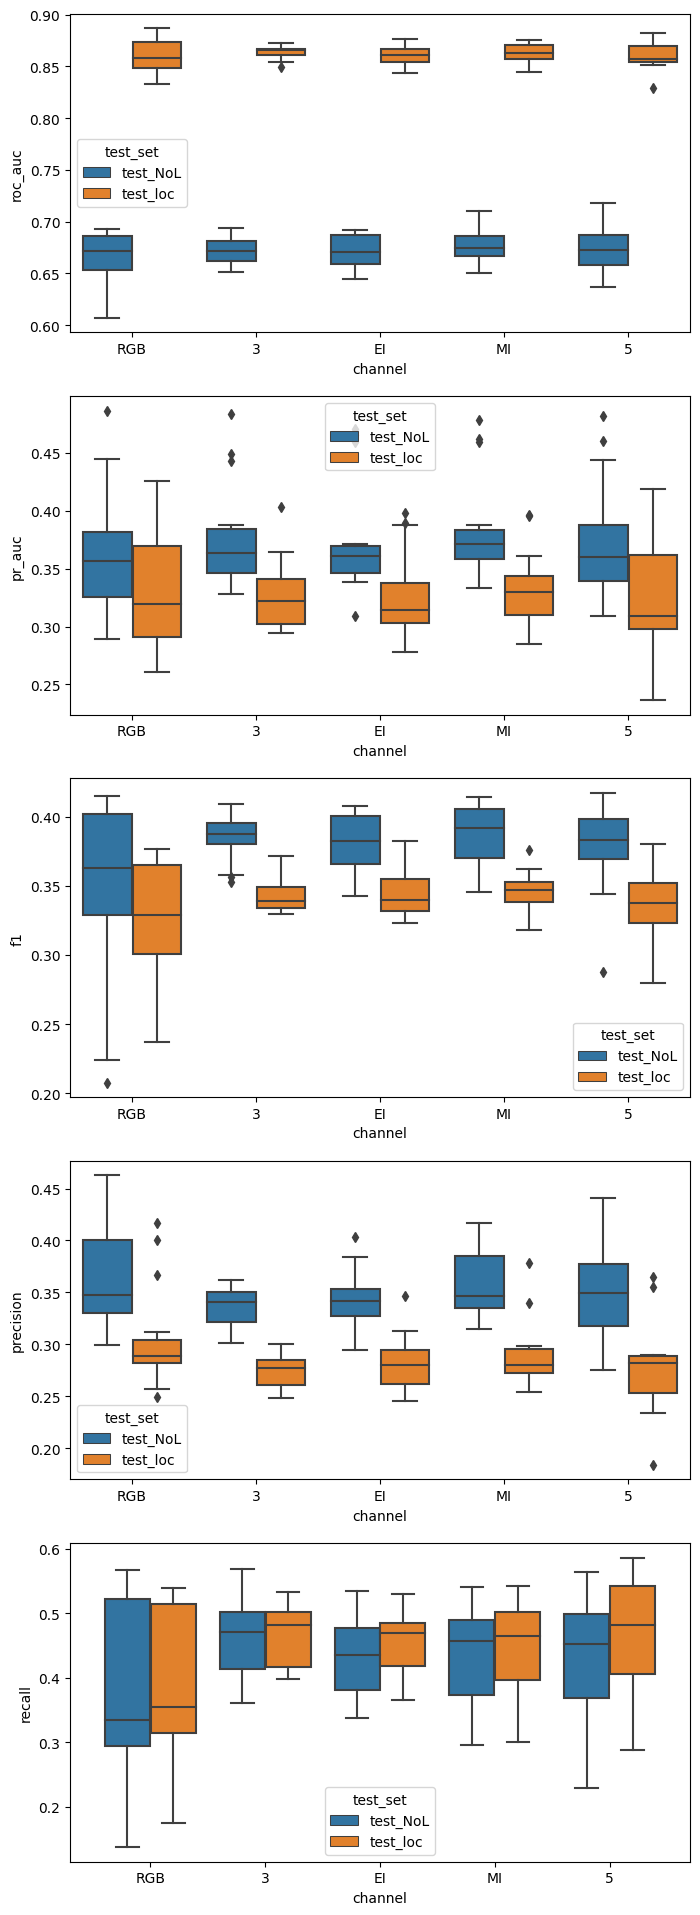

In [31]:
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(8, 24))
for i, mtr in enumerate(metrics_cols):
    sns.boxplot(df_mean_metrics_all, x = 'channel', y = mtr, hue = 'test_set', ax = axs[i])

plt.plot()
